# Notebook for merging the data sets of the tree cadastre and the watering data

In [ ]:
import pandas as pd
import geopandas as gpd

df_water = pd.read_csv("data/cleaned_bewaesserungsdaten.csv")

gdf_trees = gpd.read_file("data/berlin_strassenbaeume.geojson")


In [16]:
# normalize column names
df_water.columns = df_water.columns.str.lower().str.replace(" ", "_")
gdf_trees.columns = gdf_trees.columns.str.lower().str.replace(" ", "_")

df_water["date"] = pd.to_datetime(df_water["date"]).dt.normalize()
df_water["bewaesserungsmenge_in_liter"] = pd.to_numeric(
    df_water["bewaesserungsmenge_in_liter"], errors="coerce"
)


df_water.head()

,id,lng,lat,bezirk,art_dtsch,gattung_deutsch,strname,pflanzjahr,bewaesserungsmenge_in_liter,date,year,month
0,00008100:00224e5d,13.30562,52.46547,Steglitz-Zehlendorf,Spitz-Ahorn,AHORN,Englerallee,2017.0,7.0,2025-10-22,2025.0,10.0
1,00008100:001417f0,13.36017,52.48880,Tempelhof-Schöneberg,Silber-Linde 'Szeleste',LINDE,Erdmannstraße,2020.0,100.0,2025-10-21,2025.0,10.0
2,00008100:001f5836,13.49687,52.57073,Lichtenberg,Holländische Linde,LINDE,Zingster Straße,1989.0,30.0,2025-10-17,2025.0,10.0
3,00008100:0017d340,13.43520,52.55603,Pankow,Holländische Linde,LINDE,Jacobsohnstraße,1994.0,20.0,2025-10-17,2025.0,10.0
4,00008100:001abc75,13.59403,52.51573,Marzahn-Hellersdorf,Spitz-Ahorn,AHORN,Zanderstraße,1996.0,20.0,2025-10-16,2025.0,10.0


In [17]:
df_water_agg = df_water.groupby('id').agg(
    total_volume=('bewaesserungsmenge_in_liter', 'sum'),
    events=('bewaesserungsmenge_in_liter', 'count'),
    last_watered=('date', 'max')
).reset_index()
df_water_agg.head()


,id,total_volume,events,last_watered
0,00008100:000bbbf8,10.0,1,NaT
1,00008100:000bbbf9,395.0,38,NaT
2,00008100:000bbbfa,380.0,38,NaT
3,00008100:000bbbfb,370.0,37,NaT
4,00008100:000bbbfc,360.0,36,NaT


In [18]:
df_water_agg.describe(include='all')


,id,total_volume,events,last_watered
count,11242,11242.000000,11242.000000,5753
unique,11242,NaN,NaN,NaN
top,00008100:000bbbf8,NaN,NaN,NaN
freq,1,NaN,NaN,NaN
mean,NaN,199.581391,5.203700,2023-08-12 06:56:45.388492800
min,NaN,1.000000,1.000000,2022-04-02 00:00:00
25%,NaN,25.000000,1.000000,2022-07-24 00:00:00
50%,NaN,61.500000,2.000000,2022-09-04 00:00:00
75%,NaN,180.000000,5.000000,2024-09-06 00:00:00
max,NaN,8725.000000,736.000000,2025-11-05 00:00:00


In [19]:
df_water_agg.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11242 entries, 0 to 11241
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            11242 non-null  object        
 1   total_volume  11242 non-null  float64       
 2   events        11242 non-null  int64         
 3   last_watered  5753 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 351.4+ KB


In [20]:

# merge to keep all trees
gdf_merged = gdf_trees.merge(
    df_water_agg,
    left_on="pitid",
    right_on="id",
    how="left"
)

# add flag for trees with watering
gdf_merged['has_watering'] = gdf_merged['events'].fillna(0) > 0

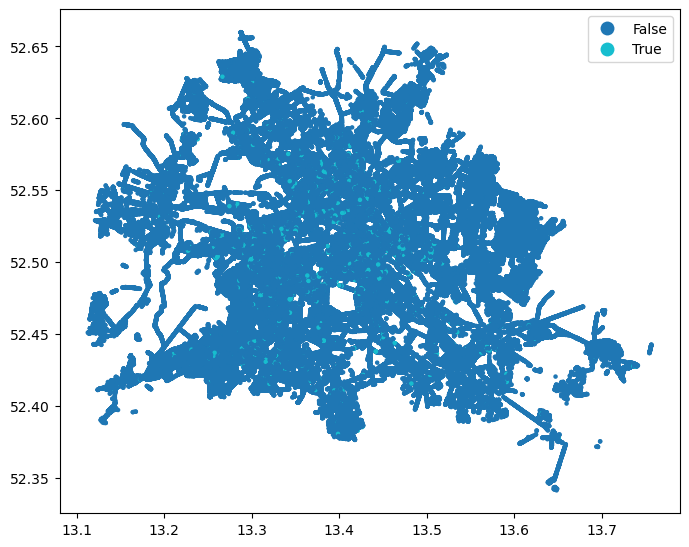

In [22]:
ax = gdf_merged.plot(
    column='has_watering',
    legend=True,
    figsize=(8,8),
    markersize=5
)

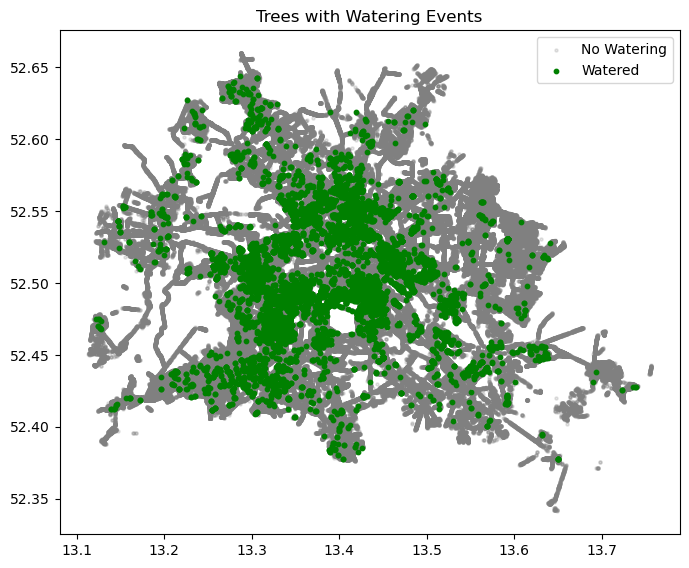

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

# Plot false points first (transparent)
gdf_merged[gdf_merged['has_watering'] == False].plot(
    ax=ax,
    color='grey',
    alpha=0.2,
    markersize=5,
    zorder=1,
    label='No Watering'
)

# Plot true points on top (solid color)
gdf_merged[gdf_merged['has_watering'] == True].plot(
    ax=ax,
    color='green',
    markersize=10,
    zorder=2,
    label='Watered'
)

ax.set_title("Trees with Watering Events")
ax.legend()
plt.show()
